In [47]:
import pathlib
import random
import cv2
import os

import zipfile, os
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf

from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import PIL
from PIL import Image

print(tf.__version__)

2.8.2


In [48]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# remove ipynb checkpoint in dataset
!rm -rf /content/drive/MyDrive/animal_training.zip/.ipynb_checkpoints

In [50]:
data_zip = '/content/drive/MyDrive/animal_training.zip'
zip_read = zipfile.ZipFile(data_zip, 'r')
zip_read.extractall('/content')
zip_read.close()

base_dir = '/content/animal_training'
base_ds = pathlib.Path(base_dir)

In [51]:
os.listdir('/content/animal_training')

['hen', 'cow', 'butterfly', 'elephant', 'cats', 'horse', 'dogs']

Image dimensions: (454, 640, 3)


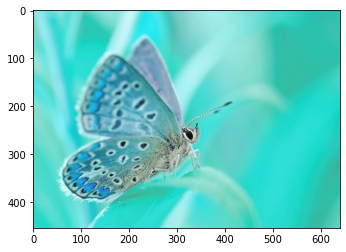

In [56]:
sample_img = cv2.imread('/content/animal_training/butterfly/e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

Image dimensions: (400, 600, 3)


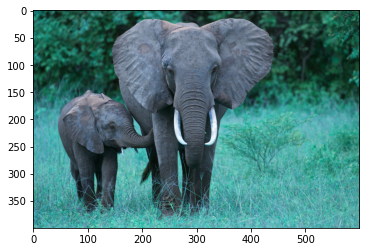

In [57]:
sample_img = cv2.imread('/content/animal_training/elephant/1447.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

Image dimensions: (300, 182, 3)


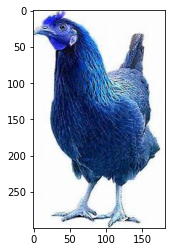

In [58]:
sample_img = cv2.imread('/content/animal_training/hen/2.jpeg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [59]:
base_dir = '/content/'
train_dir = os.path.join(base_dir, 'animal_training')

In [60]:
train_datagen = ImageDataGenerator(
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2)

In [61]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        subset = 'training',
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        train_dir, # direktori data validasi
        subset = 'validation',
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, 
        class_mode='categorical')

Found 10169 images belonging to 7 classes.
Found 2032 images belonging to 7 classes.


In [62]:
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3

In [63]:
inceptionV3 = InceptionV3(include_top= False, input_shape=(150,150,3))

for layer in inceptionV3.layers:
	layer.trainable = False

In [64]:
last_layer = inceptionV3.get_layer('mixed9')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [65]:
x = tf.keras.Sequential()
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(7, activation = tf.nn.softmax)(x)

model = tf.keras.Model( inceptionV3.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.00003)

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [66]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/10
318/318 [==============================] - 601s 2s/step - loss: 0.4796 - acc: 0.8599 - val_loss: 0.1339 - val_acc: 0.9577 - lr: 0.0010
Epoch 2/10
318/318 [==============================] - 587s 2s/step - loss: 0.2817 - acc: 0.9045 - val_loss: 0.1024 - val_acc: 0.9621 - lr: 0.0010
Epoch 3/10
318/318 [==============================] - ETA: 0s - loss: 0.2597 - acc: 0.9139
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
318/318 [==============================] - 592s 2s/step - loss: 0.2597 - acc: 0.9139 - val_loss: 0.1110 - val_acc: 0.9621 - lr: 0.0010
Epoch 4/10
318/318 [==============================] - 585s 2s/step - loss: 0.1889 - acc: 0.9355 - val_loss: 0.0671 - val_acc: 0.9739 - lr: 2.5000e-04
Epoch 5/10
318/318 [==============================] - 585s 2s/step - loss: 0.1703 - acc: 0.9422 - val_loss: 0.0544 - val_acc: 0.9793 - lr: 2.5000e-04
Epoch 6/10
318/318 [==============================] - 585s 2s/step - loss: 0.1646 - acc: 0.9421 - val_loss

Calculating the loss
The results are being visualized


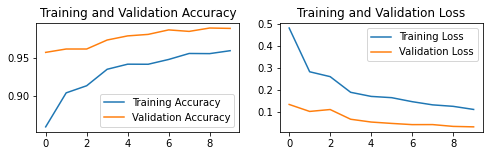

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
print("Calculating the loss")
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

epochs_range = epochs
print("The results are being visualized")
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
save_path = 'content/mymodel/'
tf.saved_model.save(model, save_path)

In [69]:
path_model = "/content/content/mymodel"
converter = tf.lite.TFLiteConverter.from_saved_model(path_model)
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)